# Analysis of optogenetic stimuli on top of drifting grating stimulus
- Variation of opto depolarization strength ("opto_depol_pct")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import pickle
# from helper_functions import load_sim_results, get_activity, plot_PSTH #, get_single_cell_psths, detect_rate_peaks
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings('ignore', message='Mean of empty slice')

In [3]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/4086d78b-e2b4-41b5-b40a-a8f130b982b3/analyses/simulations.pkl' # Max. rate scan w/o opto stim, param set 42, hex0_PV only, 50% sub-fraction, 0% opto intensities, full tuning curves

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/5e6b29a6-4cf8-44b0-a6e4-30f35a1a01ed/analyses/simulations.pkl' # Max. rate scan (v2) (with poisson spikes) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/b79678c3-182f-4520-a491-5a14cbdd9cb6/analyses/simulations.pkl' # Max. rate scan (sparsity 0.5) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/f78b83a5-ce42-4bb2-b25c-71a753deaf78/analyses/simulations.pkl' # Max. rate scan (with poisson spikes) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/f6d9d9b7-0205-429b-bff0-097faaf5ed67/analyses/simulations.pkl' # Max. rate scan (v2) (with linear mean scaling) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/c02cc5f8-8b78-40ec-9cde-04e765475357/analyses/simulations.pkl' # Max. rate scan (v2) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/aed17b53-42ea-4f99-abfb-d667a5d55598/analyses/simulations.pkl' # Max. rate scan w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/e873a484-b1e7-4d72-b6a8-9ce873004d36/analyses/simulations.pkl' # Max. rate scan (with linear mean scaling) w/o opto stim (opto_sub 0.5, opto_depol_pct 0.0, hex0_PV only) based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/visual_contrast/f50a163d-f460-4d62-a169-56eb9a241d44/analyses/simulations.pkl' # Conuctance based, opto_sub 0.5, opto_depol_pct 0-100.0, hex0_PV only, grating parameter set 98 based on James' input compensation for Ca 1.0 from 15/08/2022, after TC projection fix

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/cf612190-a8b3-458e-9e46-91d7afadbaf7/analyses/simulations.pkl' # Conuctance based, Param set 61, hex0_PV only, 50% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/c51e4277-6ebd-46c9-bb5f-541022f9ae1d/analyses/simulations.pkl' # Param set 42, hex0_SOM only, 50% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/b9331c63-8761-425e-b400-b67f7195fbc5/analyses/simulations.pkl' # Param set 42, hex0_PV only, 50% sub-fraction, 0-100% opto intensities, full tuning curves
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/275f0121-9bb9-4345-9831-5331f081bb56/analyses/simulations.pkl' # Param set 42, hex0_PV only, 50% sub-fraction, 0-100% opto intensities

### OLD (BEFORE TC FIX) ###
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/5895f796-bbdf-43f1-8774-8631418c51af/analyses/simulations.pkl' # Param set 60, hex0_PV only, 25% sub-fraction, 0-100% opto intensities

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/233f6918-3b87-4354-afc1-5f8f86df9c21/analyses/simulations.pkl' # Param set 97, hex0_PV only, mid opto intensities
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/cbd3e7f9-5933-49ff-876b-b5f7ad632e93/analyses/simulations.pkl' # Param set 60, hex0_PV only, mid opto intensities
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/cfa9a243-f1a4-4d5c-bce3-584ab9aa4179/analyses/simulations.pkl' # Param set 60, hex0_PV only, low opto intensities

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/8ff931cc-870f-4920-b6f2-7f3f2f723bfc/analyses/simulations.pkl' # Param set 60, hex0_PV only
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/322d3d58-d0fe-469c-99d5-9f2ce274dbad/analyses/simulations.pkl' # Param set 60, hex0_SOM only
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/7f0b7897-f425-490e-92ea-b36b19b6dfa3/analyses/simulations.pkl' # Param set 97, hex0_PV only
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/05974433-4cbd-4ee4-b11b-f7c4ae089a5c/analyses/simulations.pkl' # Param set 97, hex0_SOM only

# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/39619ff2-a1e4-4835-b386-d3853b6814d7/analyses/simulations.pkl' # Param set 60
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/a26ec3c1-7aef-4e58-bdac-98a406bc1f50/analyses/simulations.pkl' # Param set 97
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/4068aac5-4e36-4fb3-8ee8-5d612f13c2dd/analyses/simulations.pkl'
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/1978b10b-1508-4584-a71a-2fb8a4809d7a/analyses/simulations.pkl'
### ### ### ### ### ### ### ###

sims = pd.read_pickle(sims_file)
circuit = Simulation(sims.iloc[0]).circuit

res_path = os.path.join(os.path.split(sims_file)[0], 'output')
save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
# Load PSTH results ("single_cell_psths" launched with bbp-workflow)
psth_res_name = 'single_cell_psths'
exc_label = 'PYR' # 'EXC', 'PYR'
inh_label = 'PV' # 'INH', 'PV', 'SOM'
name_suffix_exc = '__hex0_' + exc_label
name_suffix_inh = '__hex0_' + inh_label

psth_data_exc = {}
psth_data_inh = {}
cond_names = sims.index.names
for sim_idx, (cond, cfg_path) in enumerate(sims.iteritems()):
    cond_dict = dict(zip(cond_names, cond))
    sim_id = os.path.split(os.path.split(cfg_path)[0])[-1] # Subfolder name (i.e., 000, 001, ...)
    sim_spec = '__'.join([f'{k}_{v}' for k, v in cond_dict.items()]) # Sim conditions (e.g., sparsity_1.0__rate_bk_0.2__rate_max_10.0)

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix_exc}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_exc[sim_idx] = res

    res_file = os.path.join(res_path, psth_res_name, f'{psth_res_name}{name_suffix_inh}__SIM{sim_id}__{sim_spec}.pickle')
    assert os.path.exists(res_file), f'ERROR: "{res_file}" not found!'
    with open(res_file, 'rb') as f:
        res = pickle.load(f)
    psth_data_inh[sim_idx] = res

tuning_property = sims.index.names[np.where(np.array(sims.index.levshape) > 1)[0][0]]
print(f'Tuning property: {tuning_property}')

Tuning property: rate_max


In [5]:
# Find responsive cells
def select_responsive_GIDs(psth_data, num_gids, stim_idx=0, circuit=None, layer=None):
    """Select <num_gids> most-responsive cells"""

    gids = psth_data[stim_idx]['gids']
    avg_cell_rates = psth_data[stim_idx]['avg_cell_rates']

    if layer is not None:
        assert circuit is not None, 'ERROR: Circuit when selecting a layer required!'
        lay_sel = circuit.cells.get(gids, properties='layer') == layer
    else:
        lay_sel = np.full_like(gids, True, dtype=bool)

    # Filter & sort GIDs by increasing average firing rates over all patterns
    avg_rates_sel = np.nanmean(avg_cell_rates, 0)
    avg_rates_sel[~lay_sel] = np.nan
    num_gids = np.minimum(num_gids, np.sum(~np.isnan(avg_rates_sel)))
    sort_idx = np.argsort(avg_rates_sel)[::-1] # Ordered by decreasing rate

    N_start_idx = np.sum(np.isnan(avg_rates_sel)) # Since NaNs are at beginning!!
    sel_idx = sort_idx[N_start_idx : N_start_idx + num_gids] # Selecting N gids
    gids_sel = gids[sel_idx]

    # # Select random GIDs
    # np.random.seed(0)
    # gids_sel = np.random.choice(gids, num_gids)

    return gids_sel

In [6]:
# Plot PSTHs & spikes for same set of cells for different levels of opto stim (i.e., stim 000-010)
def plot_psths(psth_data, circuit, gids_sel, contrast_sel=1.0, save_path=None, save_spec=None):
    """Plot PSTH and single-trial spikes for selected GIDs across different simulations (i.e., depol. levels)"""

    num_sims = len(psth_data)
    opto_depol_pct = [psth_data[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(num_sims)]
    depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

    patt_sel = np.unique([np.where(np.array(psth_data[sidx]['stim_cfg']['cfg']['contrast_levels']) == contrast_sel)[0][0] + len(psth_data[0]['stim_cfg']['cfg']['contrast_levels']) for sidx in  range(num_sims)])
    assert len(patt_sel) == 1, 'ERROR: Contrast selection error!'
    patt_sel = patt_sel[0] # Select pattern with given (highest) contrast + opto stim (i.e., + #contrast_levels)

    num_gids = len(gids_sel)
    plt.figure(figsize=(num_gids * 3, 6))
    for gidx in range(num_gids):
        plt.subplot(2, num_gids, gidx + 1)
        gid_depol_scale = []
        for sidx in range(num_sims):
            gid_idx = np.where(np.isin(psth_data[sidx]['gids'], gids_sel[gidx]))[0][0]

            # Get effective depol
            opto_targets = psth_data[sidx]['opto_cfg']['props']['inject_target_names']
            opto_depol = psth_data[sidx]['opto_cfg']['props']['inject_strengths']
            tgt_idx = np.where([gids_sel[gidx] in circuit.cells.ids(tgt) for tgt in opto_targets])[0]
            if len(tgt_idx) == 0:
                gid_depol_scale.append(0.0)
            else:
                gid_depol_scale.append(np.nan if opto_depol_pct[sidx] == 0.0 else opto_depol[tgt_idx[0]] / opto_depol_pct[sidx])

            rates_sel = psth_data[sidx]['rates'][patt_sel][gid_idx, :]
            t_rate = psth_data[sidx]['t_rate']
            plt.plot(t_rate, rates_sel, label=f'{opto_depol_pct[sidx]:.0f}%', color=depol_colors[sidx, :])
            x_lim = plt.xlim()
        if gidx == num_gids - 1:
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), title='Opto depol.')
        plt.ylabel('Rate (Hz)')

        cell_layer = circuit.cells.get(gids_sel[gidx], properties='layer')
        cell_class = circuit.cells.get(gids_sel[gidx], properties='synapse_class')
        assert np.nanstd(gid_depol_scale) < 1e-12, 'ERROR: Same depol. scaling across all sims expected!'
        plt.title(f'GID {gids_sel[gidx]} (L{cell_layer}, {cell_class})\nEff. depol.: {100.0 * np.nanmean(gid_depol_scale):.1f}%', fontweight='bold')

        plt.subplot(2, num_gids, gidx + num_gids + 1)
        for sidx in range(num_sims):
            spike_trials = psth_data[sidx]['spike_trains'][patt_sel][gids_sel[gidx]]
            for trial, st in enumerate(spike_trials):
                plt.plot(st, np.full(len(st), (trial + 0.5) / len(spike_trials) + sidx), '|', markersize=1.0, color=depol_colors[sidx, :])
        plt.xlim(x_lim)
        plt.ylim((0, num_sims))
        plt.yticks(np.arange(num_sims + 1), labels=[])
        plt.grid(axis='y')
        plt.xlabel('Time (ms)')
        plt.ylabel('Single-trial spikes')
    plt.suptitle(f'Contrast level {contrast_sel}', fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        if layer is not None:
            save_spec = f'{save_spec}_L{layer}'
        plt.savefig(os.path.join(save_path, f'PSTHs_sel_{num_gids}GIDs_c{contrast_sel}{save_spec}.png'), dpi=300)
    plt.show()

In [ ]:
# Plot selected INH PSTHs per layer (high contrast)
for layer in [1, 2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_inh, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_psths(psth_data_inh, circuit, gids_sel, contrast_sel=1.0, save_path=save_path, save_spec=inh_label)

In [ ]:
# Plot selected INH PSTHs per layer (low contrast)
for layer in [1, 2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_inh, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_psths(psth_data_inh, circuit, gids_sel, contrast_sel=0.06, save_path=save_path, save_spec=inh_label)

In [ ]:
# Plot selected EXC PSTHs per layer (high contrast)
for layer in [2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_exc, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_psths(psth_data_exc, circuit, gids_sel, contrast_sel=1.0, save_path=save_path, save_spec=exc_label)

In [ ]:
# Plot selected EXC PSTHs per layer (low contrast)
for layer in [2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_exc, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_psths(psth_data_exc, circuit, gids_sel, contrast_sel=0.06, save_path=save_path, save_spec=exc_label)

In [7]:
# Compute tuning curves
def compute_tuning(psth_data, resp_int, base_int, do_norm=False, norm_contrast=None, norm_opto=None, norm_once=None):
    """Computes single-cell tuning with or without normalization"""
#     resp_int = [0, 1000] # Response interval (ms) to extract time-averaged rates for tuning curves
#     base_int = [1000, 2000] # Baseline interval (ms) w/o stimulation
#     norm_contrast = 1.0 # Contrast level used for normalization
#     norm_opto = True # Use contrast + opto stim pattern for normalization
#     norm_once = True # Compute normalization only once based on first sim's rates
#     do_norm = True

    sim_ids = list(psth_data.keys())
    contrasts = None # Contrast levels
    tuning_curves = [] # Normalized tuning curves
    baselines = [] # Normalized baseline activities
    gids = []
    norm_rates = []
    print('PROCESSING tuning curves...', end='')
    for sim_idx in sim_ids:
        print(f' {sim_idx}', end='')

        if contrasts is None:
            contrasts = psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels']
        else:
            assert np.all(np.array(contrasts) == psth_data[sim_idx]['stim_cfg']['cfg']['contrast_levels'])

        t_rate = psth_data[sim_idx]['t_rate']
        num_patterns = int(len(psth_data[sim_idx]['rates']) / 2)
        patt_ind = list(range(num_patterns)) # Indices for raw contrast patterns
        opto_ind = list(range(num_patterns, 2 * num_patterns)) # Indices for contrast patterns with opto stim
        if do_norm:
            assert norm_contrast in contrasts, 'ERROR: Normalisation contrast level not found!'
            norm_idx = np.where(np.array(contrasts) == norm_contrast)[0][0]
            if norm_opto:
                norm_idx = norm_idx + len(contrasts) # Pattern with opto stim

        if len(gids) == 0:
            gids = psth_data[sim_idx]['gids']
            num_cells = len(gids)
        else:
            assert np.array_equal(gids, psth_data[sim_idx]['gids']), 'ERROR: GIDs mismatch across simulations!'
        avg_responses = []
        avg_baseline = []
        norm_responses = [] # Normalized rates based on max. rate at given norm_contrast level (w/o opto!)
        norm_baseline = [] # Normalized baseline rates based on max. rate at given norm_contrast level (w/o opto!)
        for gidx, gid in enumerate(gids):
            resp_rates = []
            base_rates = []
            for p in range(2 * num_patterns):
                spike_trains = psth_data[sim_idx]['spike_trains'][p][gid]
                resp_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= resp_int[0], np.array(st) < resp_int[-1])) / np.diff(resp_int)[0] for st in spike_trains])
                base_rates.append([1e3 * np.sum(np.logical_and(np.array(st) >= base_int[0], np.array(st) < base_int[-1])) / np.diff(base_int)[0] for st in spike_trains])
            avg_responses.append(resp_rates)
            avg_baseline.append(base_rates)
            if do_norm:
                norm_rate = np.mean(resp_rates[norm_idx]) # Maximum rate used for normalization
                if norm_once:
                    if len(norm_rates) == len(gids):
                        norm_rate = norm_rates[gidx]
                    else:
                        norm_rates.append(norm_rate)
            else:
                norm_rate = 1.0 # No normalization
            norm_responses.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in resp_rates[p]] for p in range(2 * num_patterns)])
            norm_baseline.append([[r / norm_rate if norm_rate > 0.0 else np.nan for r in base_rates[p]] for p in range(2 * num_patterns)])

        def resp_stat(responses, fct):
            """Computes statistics given by fct over response trials"""
            return np.array([[fct(r) if len(r) > 0 else np.nan for r in rr] for rr in responses])

        contr_resp_func = {}
        contr_resp_func.update({'mean': resp_stat(norm_responses, np.mean)})
        contr_resp_func.update({'std': resp_stat(norm_responses, np.std)})
        contr_resp_func.update({'N': resp_stat(norm_responses, len)})
        contr_resp_func.update({'sem': contr_resp_func['std'] / np.sqrt(contr_resp_func['N'])})

        baseline_activity = {}
        baseline_activity.update({'mean': resp_stat(norm_baseline, np.mean)})
        baseline_activity.update({'std': resp_stat(norm_baseline, np.std)})
        baseline_activity.update({'N': resp_stat(norm_baseline, len)})
        baseline_activity.update({'sem': baseline_activity['std'] / np.sqrt(baseline_activity['N'])})

        tuning_curves.append(contr_resp_func)
        baselines.append(baseline_activity)

    return tuning_curves, baselines, gids

In [8]:
def plot_tuning(psth_data, tuning_curves, circuit, gids, contrast_list, is_norm, y_lim=None, save_path=None, save_spec=None):
    """Plots tuning for different levels of opto sim (i.e., sims), averaged within layers"""

    num_sims = len(psth_data)
    opto_depol_pct = [psth_data[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(num_sims)]
    depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

    syn_class = np.unique(circuit.cells.get(gids, properties='synapse_class'))
    assert len(syn_class) == 1, 'ERROR: Single synapse class expected!'
    syn_class = syn_class[0]
    gid_layers = circuit.cells.get(gids, properties='layer').to_numpy()
    layers = np.unique(gid_layers)
    lay_colors = plt.cm.viridis(np.linspace(0, 1, max(layers)))

    plt.figure(figsize=(1 + 5 * len(contrast_list), 5))
    for cidx, contr in enumerate(contrast_list):
        plt.subplot(1, len(contrast_list), cidx + 1)
        patt_sel = np.unique([np.where(np.array(psth_data[sidx]['stim_cfg']['cfg']['contrast_levels']) == contr)[0][0] + len(psth_data[0]['stim_cfg']['cfg']['contrast_levels']) for sidx in  range(num_sims)])
        assert len(patt_sel) == 1, 'ERROR: Contrast selection error!'
        patt_sel = patt_sel[0] # Select pattern with given (highest) contrast + opto stim (i.e., + #contrast_levels)

        for lidx, lay in enumerate(layers):
            gidx = gid_layers == lay
            lay_tuning = np.array([tuning_curves[sidx]['mean'][gidx, patt_sel] for sidx in range(num_sims)])
            num_valid = np.sum(np.all(~np.isnan(lay_tuning), 0))
            plt.errorbar(opto_depol_pct, np.nanmean(lay_tuning, 1), yerr=np.nanstd(lay_tuning, 1) / np.sqrt(num_valid), color=lay_colors[lidx, :], marker='.', label=f'L{lay} (N={lay_tuning.shape[1]})')
        plt.ylim(y_lim)
        plt.grid()
        plt.xlabel('INH opto depol. (%)')
        if is_norm:
            plt.ylabel('Norm. firing rate [$\mu$ $\pm$ SEM]')
        else:
            plt.ylabel('Firing rate (Hz) [$\mu$ $\pm$ SEM]')
        plt.title(f'Contrast level {contr}', fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.suptitle(f'{syn_class} tuning', fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'{syn_class}_tuning{save_spec}.png'), dpi=300)
    plt.show()

In [9]:
# Compute INH tuning
tuning_curves_inh, baselines_inh, gids_inh = compute_tuning(psth_data_inh, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

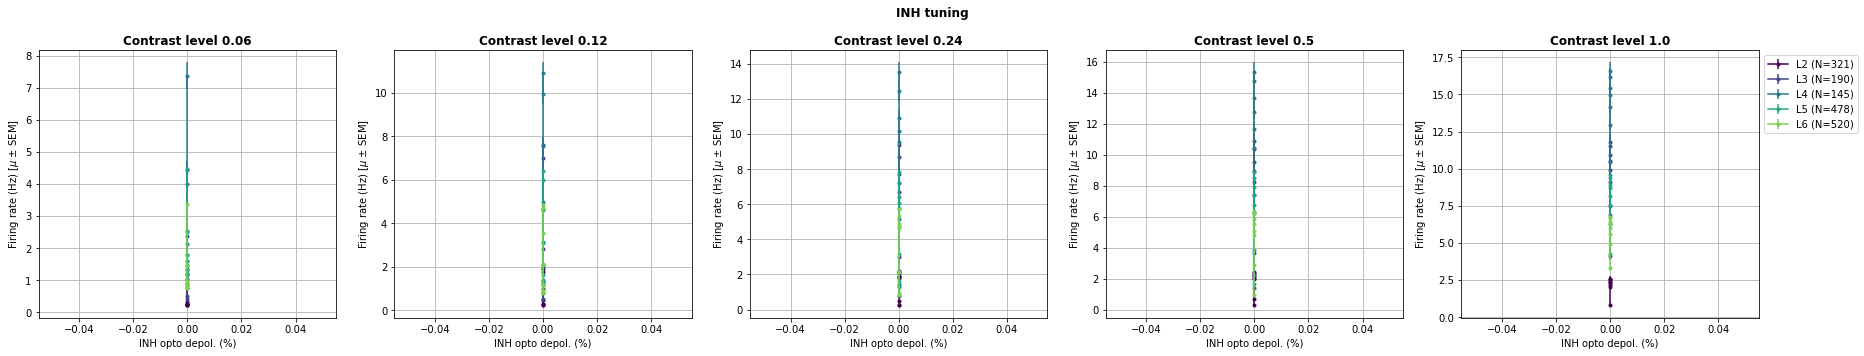

In [10]:
# Plot INH tuning
plot_tuning(psth_data_inh, tuning_curves_inh, circuit, gids_inh, contrast_list=[0.06, 0.12, 0.24, 0.5, 1.0], is_norm=False, y_lim=None, save_path=save_path)

In [11]:
# Compute EXC tuning
tuning_curves_exc, baselines_exc, gids_exc = compute_tuning(psth_data_exc, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=False)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7

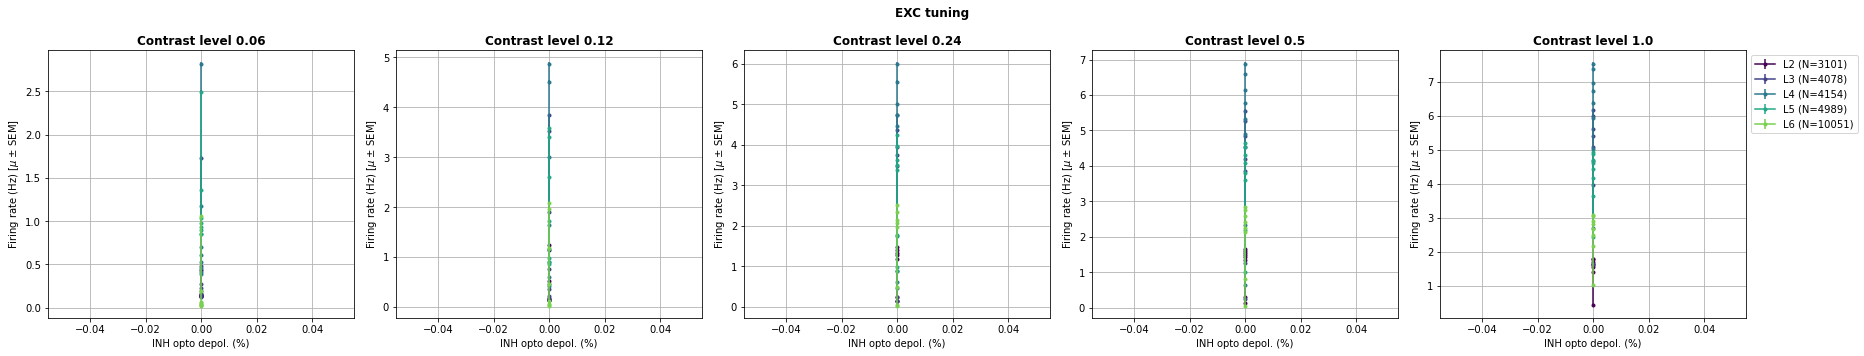

In [12]:
# Plot EXC tuning
plot_tuning(psth_data_exc, tuning_curves_exc, circuit, gids_exc, contrast_list=[0.06, 0.12, 0.24, 0.5, 1.0], is_norm=False, y_lim=None, save_path=save_path)

In [13]:
def plot_diff_tuning(psth_data, tuning_curves, circuit, gids, contrast_diff, is_norm, y_lim=None, save_path=None, save_spec=None):
    """Plots tuning difference (between given contrasts) for different levels of opto sim (i.e., sims),
       averaged within layers"""

    num_sims = len(psth_data)
    opto_depol_pct = [psth_data[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(num_sims)]
    depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

    syn_class = np.unique(circuit.cells.get(gids, properties='synapse_class'))
    assert len(syn_class) == 1, 'ERROR: Single synapse class expected!'
    syn_class = syn_class[0]
    gid_layers = circuit.cells.get(gids, properties='layer').to_numpy()
    layers = np.unique(gid_layers)
    lay_colors = plt.cm.viridis(np.linspace(0, 1, max(layers)))

    assert len(contrast_diff) == 2, 'ERROR: Two contrasts for computing tuning difference required!'
    patt_sel_diff = []
    for contr in contrast_diff:
        patt_sel = np.unique([np.where(np.array(psth_data[sidx]['stim_cfg']['cfg']['contrast_levels']) == contr)[0][0] + len(psth_data[0]['stim_cfg']['cfg']['contrast_levels']) for sidx in  range(num_sims)])
        assert len(patt_sel) == 1, 'ERROR: Contrast selection error!'
        patt_sel = patt_sel[0] # Select pattern with given (highest) contrast + opto stim (i.e., + #contrast_levels)
        patt_sel_diff.append(patt_sel)

    plt.figure(figsize=(6, 5))
    for lidx, lay in enumerate(layers):
        gidx = gid_layers == lay
        lay_tuning = np.array([tuning_curves[sidx]['mean'][gidx, patt_sel_diff[1]] - tuning_curves[sidx]['mean'][gidx, patt_sel_diff[0]] for sidx in range(num_sims)])
        num_valid = np.sum(np.all(~np.isnan(lay_tuning), 0))
        plt.errorbar(opto_depol_pct, np.nanmean(lay_tuning, 1), yerr=np.nanstd(lay_tuning, 1) / np.sqrt(num_valid), color=lay_colors[lidx, :], marker='.', label=f'L{lay} (N={lay_tuning.shape[1]})')
    plt.ylim(y_lim)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.grid()
    plt.xlabel('INH opto depol. (%)')
    if is_norm:
        plt.ylabel('Norm. firing rate difference [$\mu$ $\pm$ SEM]')
    else:
        plt.ylabel('Firing rate difference (Hz) [$\mu$ $\pm$ SEM]')
    plt.title(f'{syn_class} diff tuning between contrasts {contrast_diff[1]} and {contrast_diff[0]}', fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'{syn_class}_diff_tuning{save_spec}.png'), dpi=300)
    plt.show()

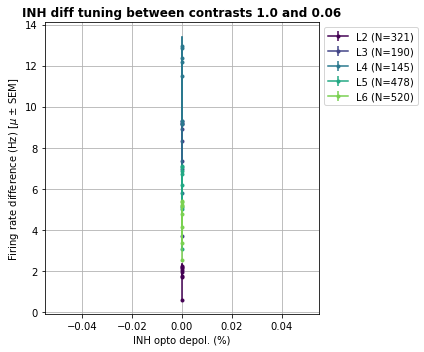

In [14]:
# Plot INH diff tuning
plot_diff_tuning(psth_data_inh, tuning_curves_inh, circuit, gids_inh, contrast_diff=[0.06, 1.0], is_norm=False, y_lim=None, save_path=save_path)

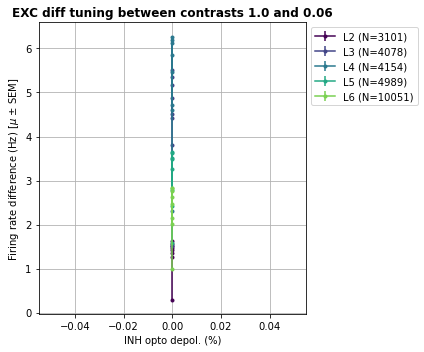

In [15]:
# Plot EXC diff tuning
plot_diff_tuning(psth_data_exc, tuning_curves_exc, circuit, gids_exc, contrast_diff=[0.06, 1.0], is_norm=False, y_lim=None, save_path=save_path)

In [16]:
# Compute normalized INH tuning
norm_tuning_curves_inh, norm_baselines_inh, gids_inh = compute_tuning(psth_data_inh, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7

In [17]:
# Compute normalized EXC tuning
norm_tuning_curves_exc, norm_baselines_exc, gids_exc = compute_tuning(psth_data_exc, resp_int=[0, 1000], base_int=[1000, 2000], do_norm=True, norm_contrast=1.0, norm_opto=True, norm_once=True)

PROCESSING tuning curves... 0 1 2 3 4 5 6 7

In [18]:
def plot_modulated_contrast_response_function(tuning_curves, baselines, gids, gids_sel, contrasts, opto_depol_pct, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim"""
    num_sims = len(opto_depol_pct)
    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    plt.figure(figsize=(21, 3))
    for idx, gid in enumerate(gids_sel):
        gid_idx = np.where(gids == gid)[0][0]
        plt.subplot(1, len(gids_sel), idx + 1)
        for sidx in range(num_sims):
            if opto_depol_pct[sidx] == 0.0:
                plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, pidx]), tuning_curves[sidx]['mean'][gid_idx, pidx])), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, pidx]), tuning_curves[sidx]['sem'][gid_idx, pidx])), color=depol_colors[sidx, :], label=f'{opto_depol_pct[sidx]}%')
            else:
                plt.errorbar(range(1, num_patterns + 1), tuning_curves[sidx]['mean'][gid_idx, pidx], yerr=tuning_curves[sidx]['sem'][gid_idx, pidx], color=depol_colors[sidx, :], label=f'{opto_depol_pct[sidx]}%')
        plt.xlim((-0.25, num_patterns + 0.25))
        plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
        plt.xlabel('Contrast')
        if idx == 0:
            plt.ylabel('Norm. rate')
        plt.grid()
        plt.title(f'GID{gid}', fontweight='bold')
    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

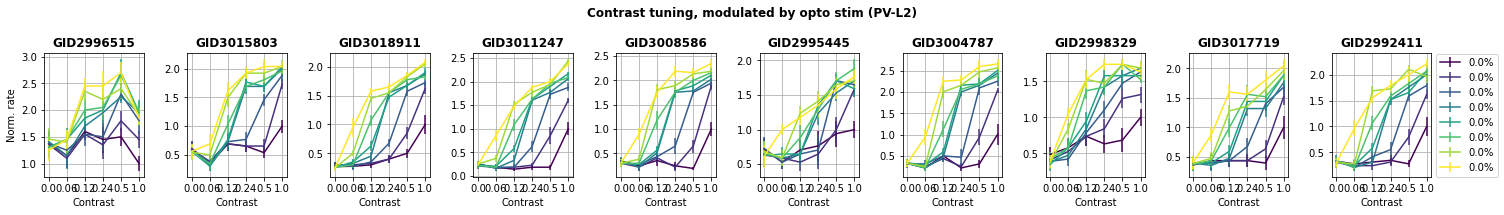

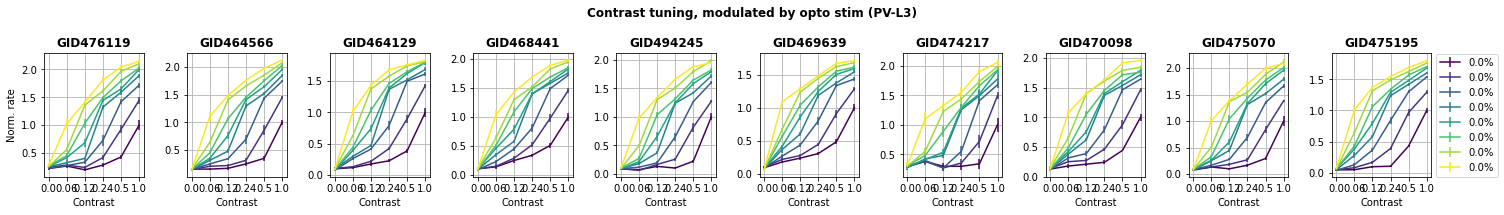

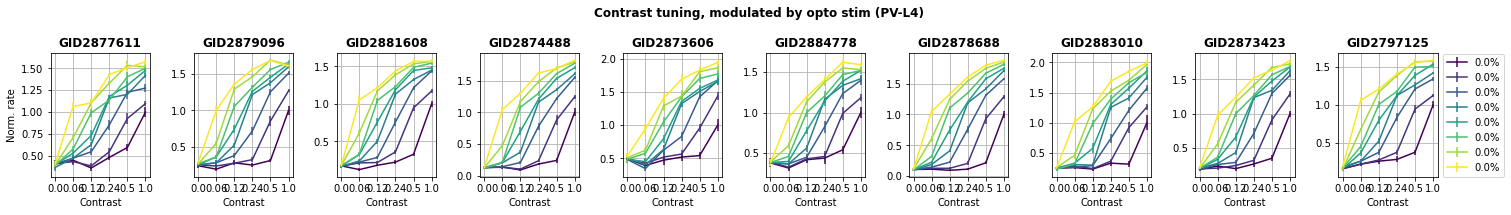

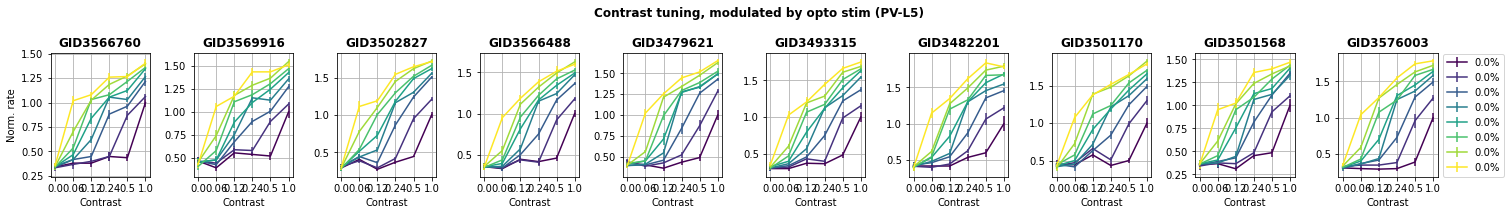

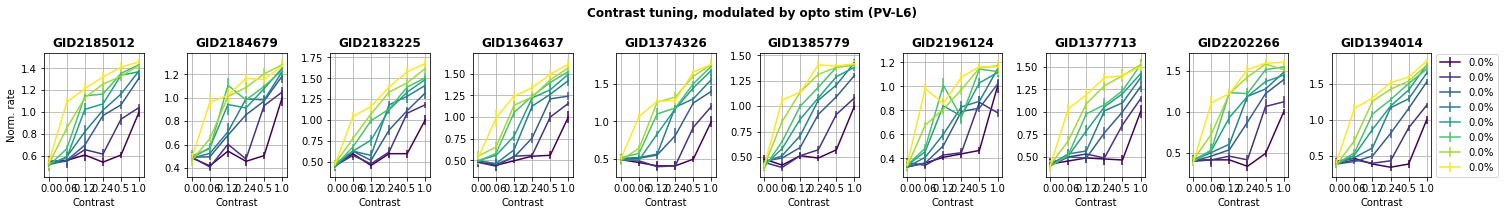

In [19]:
# Plot INH contrast tuning, modulated by opto stim
opto_depol_pct = [psth_data_inh[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data_inh))]
contrasts = psth_data_inh[0]['stim_cfg']['cfg']['contrast_levels']

for layer in [1, 2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_inh, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_modulated_contrast_response_function(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, gids_sel, contrasts, opto_depol_pct, save_path=save_path, save_spec=f'{inh_label}-L{layer}')

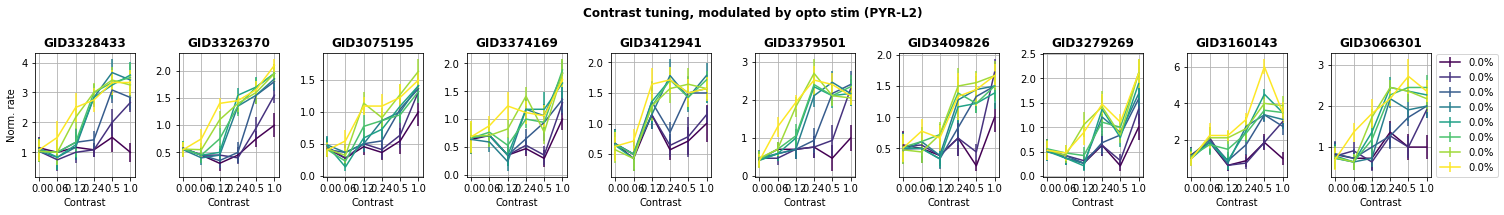

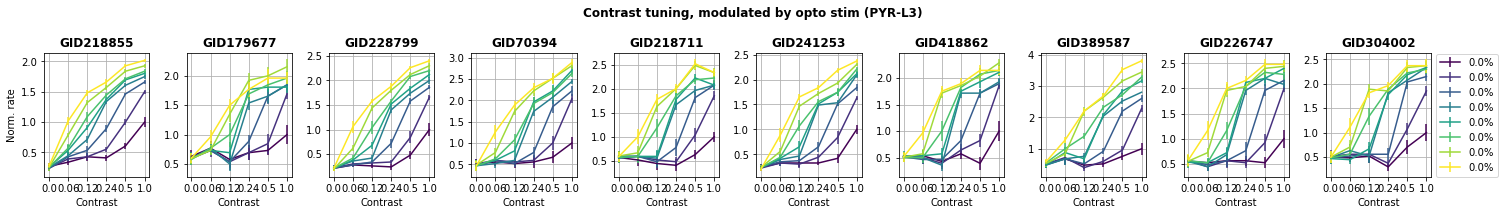

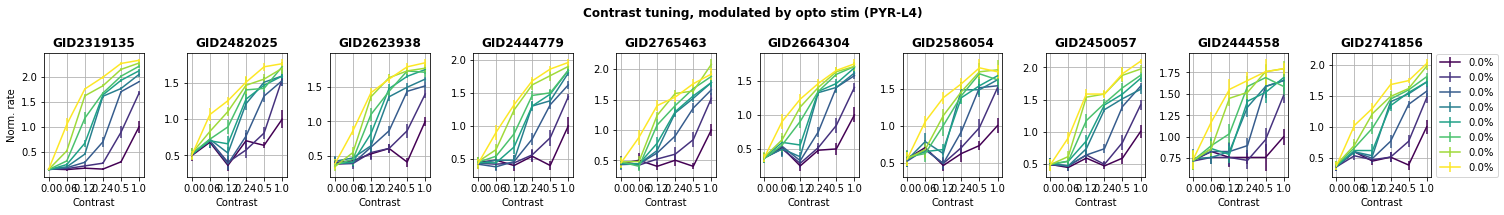

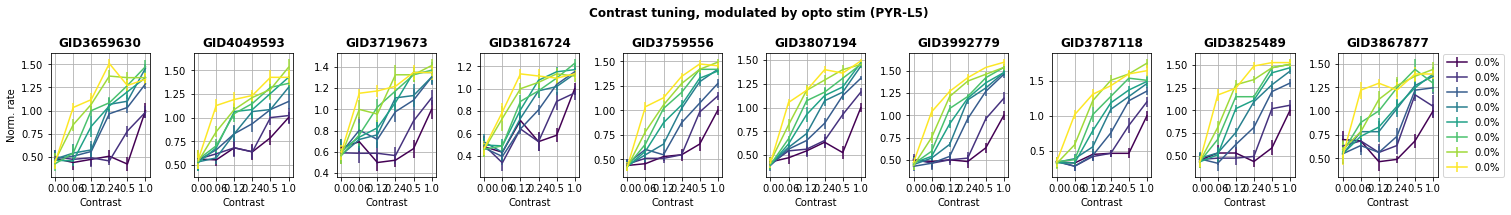

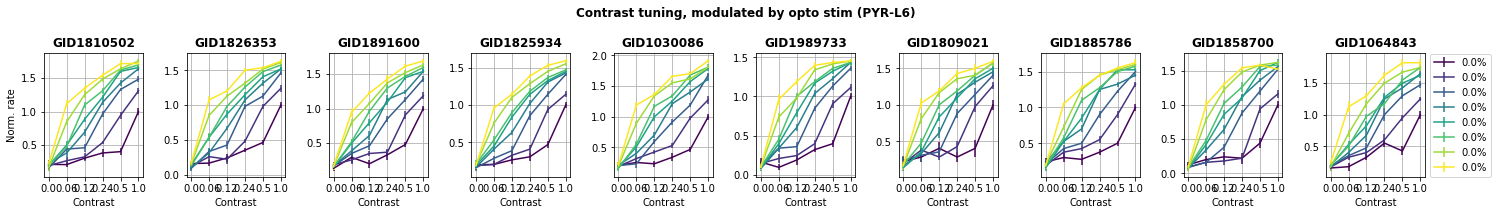

In [20]:
# Plot EXC contrast tuning, modulated by opto stim
opto_depol_pct = [psth_data_exc[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data_exc))]
contrasts = psth_data_exc[0]['stim_cfg']['cfg']['contrast_levels']

for layer in [2, 3, 4, 5, 6]:
    gids_sel = select_responsive_GIDs(psth_data_exc, num_gids=10, stim_idx=0, circuit=circuit, layer=layer)
    if len(gids_sel) > 0:
        plot_modulated_contrast_response_function(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, gids_sel, contrasts, opto_depol_pct, save_path=save_path, save_spec=f'{exc_label}-L{layer}')

In [21]:
def plot_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuit, contrasts, tuning_values, merged_layers=None, save_path=None, save_spec=None, num_y_zoom=None, tuning_property=None, title_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim"""
    num_sims = len(tuning_values)
    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuit.cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    plt.figure(figsize=(12, 3))
    for lidx, layer in enumerate(layers):
        plt.subplot(1, len(layers), lidx + 1)
        gids_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]

        depol_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
        gid_idx = np.where(np.isin(gids, gids_sel))[0]
        gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
        assert len(gid_idx) > 0, 'ERROR: No GIDs selected!'
        for sidx in range(num_sims):
            if tuning_property is not None and '_pct' in tuning_property:
                lbl = f'{tuning_values[sidx]}%'
            else:
                lbl = f'{tuning_values[sidx]}'
            if tuning_values[sidx] == 0.0:
                plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=depol_colors[sidx, :], label=lbl)
            else:
                plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=depol_colors[sidx, :], label=lbl)
        plt.xlim((-0.25, num_patterns + 0.25))
        if num_y_zoom is not None:
            pidx_sel = np.arange(num_y_zoom) + num_patterns
            zoomed_data_min = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) - np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            zoomed_data_max = [np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx_sel], 0) + np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx_sel], 0) for sidx in range(num_sims)]
            plt.ylim([np.min(zoomed_data_min), np.max(zoomed_data_max)])
        plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
        plt.xlabel('Contrast')
        plt.ylabel('Norm. rate')
        plt.grid()
#         plt.gca().spines['top'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)
        plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer} (N={len(gid_idx)})')
    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], title=tuning_property)
    if isinstance(title_spec, str):
        title_spec = ' ' + title_spec
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()


def plot_split_mean_modulated_contrast_response_function_per_layer(tuning_curves, baselines, gids, circuits, opto_props, contrasts, tuning_values, merged_layers=None, tuning_property=None, save_path=None, save_spec=None):
    """Plot contrast response functions (norm. contrast tuning curves) modulated by opto stim,
       splitted into cells that are (not) targeted by opto stimulus"""
    num_sims = len(tuning_values)
    assert len(circuits) == num_sims, f'ERROR: List of {num_sims} circuits required!'
    assert len(opto_props) == num_sims, f'ERROR: List of {num_sims} opto property dicts required!'

    num_patterns = len(contrasts)
    pidx = np.arange(num_patterns) + num_patterns # Pattern indices with opto stim (i.e., starting at <num_patterns>)

    layers = list(np.unique(circuits[0].cells.get(gids, properties='layer')))
    if merged_layers is not None:
        for mlay in merged_layers: # List of lists expeted
            layers = list(np.setdiff1d(layers, mlay)) # Remove single layers from list
            layers.append(mlay) # Add merged layers to list
            layers = sorted(layers, key=lambda x: x[0] if isinstance(x, list) else x) # Re-sort based on first of merged layers

    level_colors = plt.cm.viridis(np.linspace(0, 1, num_sims))
    tgt_ls = ['--', '-'] # Line styles for non-targeted/targeted cells

    plt.figure(figsize=(12, 3))
    print(f'Plotting ({num_sims} steps)...', end='')
    for sidx in range(num_sims):
        print(f'{sidx + 1}', end=' ')
        # Select targeted/non-targeted GIDs
        tgt_gids = []
        for tgt in opto_props[sidx]['inject_target_names']:
            tgt_gids.append(circuits[sidx].cells.ids(tgt))
        if len(tgt_gids) > 0:
            tgt_gids = np.unique(np.hstack(tgt_gids))

        for lidx, layer in enumerate(layers):
            plt.subplot(1, len(layers), lidx + 1)
            gids_lay_sel = gids[np.isin(circuit.cells.get(gids, properties='layer'), layer)]
            gids_sel_tgt = np.intersect1d(gids_lay_sel, tgt_gids)
            gids_sel_nontgt = np.setdiff1d(gids_lay_sel, gids_sel_tgt)

            for sel_idx, gids_sel in enumerate([gids_sel_nontgt, gids_sel_tgt]):
                gid_idx = np.where(np.isin(gids, gids_sel))[0]
                gid_idx = gid_idx[~np.any(np.isnan(baselines[0]['mean'][gid_idx, :][:, pidx]), 1)] # Remove (non-responding) GIDs with invalid norm. tuning
                if len(gid_idx) == 0:
                    continue

                if sel_idx == 0:
                    lbl = f'{tuning_values[sidx]} (non-tgt)'
                else:
                    lbl = f'{tuning_values[sidx]} (tgt)'
                if tuning_values[sidx] == 0.0:
                    plt.errorbar(range(num_patterns + 1), np.hstack((np.mean(baselines[sidx]['mean'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0))), yerr=np.hstack((np.mean(baselines[sidx]['sem'][gid_idx, :][:, pidx]), np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0))), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
                else:
                    plt.errorbar(range(1, num_patterns + 1), np.mean(tuning_curves[sidx]['mean'][gid_idx, :][:, pidx], 0), yerr=np.mean(tuning_curves[sidx]['sem'][gid_idx, :][:, pidx], 0), color=level_colors[sidx, :], ls=tgt_ls[sel_idx], label=lbl)
            plt.xlim((-0.25, num_patterns + 0.25))
            plt.xticks(range(num_patterns + 1), labels=[0.0] + contrasts)
            plt.xlabel('Contrast')
            plt.ylabel('Norm. rate')
            plt.grid()
            plt.title(f'L{"".join([str(lay) for lay in layer]) if isinstance(layer, list) else layer}')

    plt.legend(loc='center left', bbox_to_anchor=[1.0, 0.5], ncol=2, title=tuning_property)
    if isinstance(save_spec, str):
        title_spec = f' ({save_spec})'
    else:
        title_spec = ''
    plt.suptitle('Contrast tuning, modulated by opto stim' + title_spec, fontweight='bold')
    plt.tight_layout()
    if save_path is not None:
        if isinstance(save_spec, str):
            save_spec = '_' + save_spec
        else:
            save_spec = ''
        plt.savefig(os.path.join(save_path, f'split_mean_norm_contrast_tuning{save_spec}.png'), dpi=300)
    plt.show()

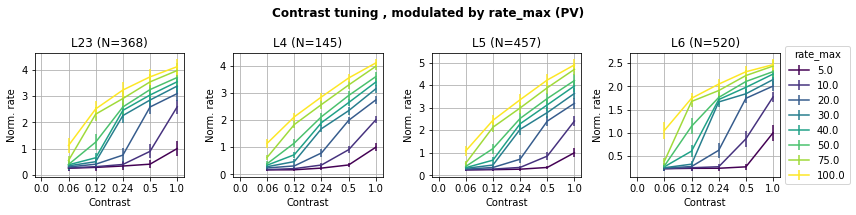

In [22]:
# Plot mean INH contrast tuning per layer, modulated by opto stim
contrasts = psth_data_inh[0]['stim_cfg']['cfg']['contrast_levels']

if tuning_property == 'opto_depol_pct':
    opto_depol_pct = [psth_data_inh[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data_inh))]
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=inh_label, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({inh_label})')
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=inh_label + '_zoomed', num_y_zoom=4, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({inh_label})')
elif tuning_property == 'rate_max':
    rate_max = [psth_data_inh[sidx]['stim_cfg']['cfg']['rate_max'] for sidx in range(len(psth_data_inh))]
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuit, contrasts, rate_max, merged_layers=[[2, 3]], save_path=save_path, save_spec=inh_label, tuning_property=tuning_property, title_spec=f', modulated by {tuning_property} ({inh_label})')

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

Plotting (8 steps)...1 2 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

3 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

4 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

5 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

6 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

7 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

8 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

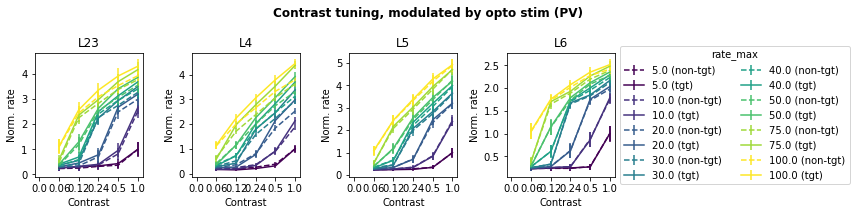

In [23]:
circuits = [Simulation(sims.iloc[sidx]).circuit for sidx in range(sims.shape[0])]
opto_props = [psth_data_inh[sidx]['opto_cfg']['props'] for sidx in range(len(psth_data_inh))]

if tuning_property == 'opto_depol_pct':
    plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuits, opto_props, contrasts, opto_depol_pct, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=inh_label)
elif tuning_property == 'rate_max':
    plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_inh, norm_baselines_inh, gids_inh, circuits, opto_props, contrasts, rate_max, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=inh_label)

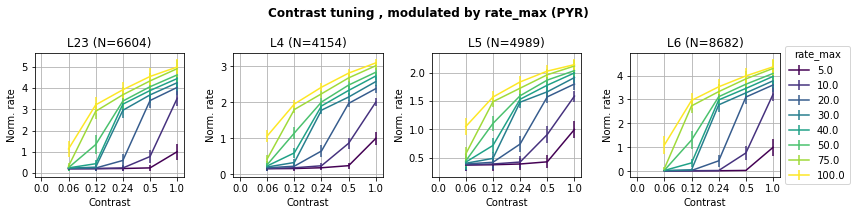

In [24]:
# Plot mean EXC contrast tuning per layer, modulated by opto stim
contrasts = psth_data_exc[0]['stim_cfg']['cfg']['contrast_levels']

if tuning_property == 'opto_depol_pct':
    opto_depol_pct = [psth_data_exc[sidx]['opto_cfg']['cfg']['opto_depol_pct'] for sidx in range(len(psth_data_exc))]
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=exc_label, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({exc_label})')
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuit, contrasts, opto_depol_pct, merged_layers=[[2, 3]], save_path=save_path, save_spec=exc_label + '_zoomed', num_y_zoom=4, tuning_property=tuning_property, title_spec=f', modulated by opto stim ({exc_label})')
elif tuning_property == 'rate_max':
    rate_max = [psth_data_inh[sidx]['stim_cfg']['cfg']['rate_max'] for sidx in range(len(psth_data_inh))]
    plot_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuit, contrasts, rate_max, merged_layers=[[2, 3]], save_path=save_path, save_spec=exc_label, tuning_property=tuning_property, title_spec=f', modulated by {tuning_property} ({exc_label})')

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

Plotting (8 steps)...1 2 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

3 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

4 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

5 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

6 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

7 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

8 

Target 'hex0_L1_PV' resolves to empty GID list
Target 'hex1_L1_PV' resolves to empty GID list
Target 'hex2_L1_PV' resolves to empty GID list
Target 'hex3_L1_PV' resolves to empty GID list
Target 'hex4_L1_PV' resolves to empty GID list
Target 'hex5_L1_PV' resolves to empty GID list
Target 'hex6_L1_PV' resolves to empty GID list
Target 'hex0_L1_SOM' resolves to empty GID list
Target 'hex1_L1_SOM' resolves to empty GID list
Target 'hex2_L1_SOM' resolves to empty GID list
Target 'hex3_L1_SOM' resolves to empty GID list
Target 'hex4_L1_SOM' resolves to empty GID list
Target 'hex5_L1_SOM' resolves to empty GID list
Target 'hex6_L1_SOM' resolves to empty GID list
Target 'hex0_L1_PYR' resolves to empty GID list
Target 'hex1_L1_PYR' resolves to empty GID list
Target 'hex2_L1_PYR' resolves to empty GID list
Target 'hex3_L1_PYR' resolves to empty GID list
Target 'hex4_L1_PYR' resolves to empty GID list
Target 'hex5_L1_PYR' resolves to empty GID list
Target 'hex6_L1_PYR' resolves to empty GID list

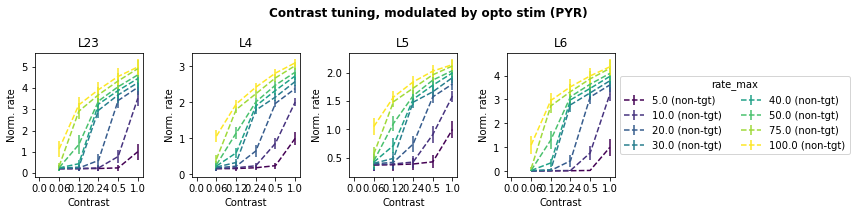

In [25]:
circuits = [Simulation(sims.iloc[sidx]).circuit for sidx in range(sims.shape[0])]
opto_props = [psth_data_exc[sidx]['opto_cfg']['props'] for sidx in range(len(psth_data_exc))]

if tuning_property == 'opto_depol_pct':
    plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuits, opto_props, contrasts, opto_depol_pct, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=exc_label)
elif tuning_property == 'rate_max':
    plot_split_mean_modulated_contrast_response_function_per_layer(norm_tuning_curves_exc, norm_baselines_exc, gids_exc, circuits, opto_props, contrasts, rate_max, merged_layers=[[2, 3]], tuning_property=tuning_property, save_path=save_path, save_spec=exc_label)

In [26]:
# # Looking into single-cell responses more closely
# sel_tgt = 'hex0_L6_PV'
# gids_sel = circuit.cells.ids(sel_tgt)
# gids_sel_idx = np.where(np.isin(gids_inh, gids_sel))[0]

# inh_tuning_mean = norm_tuning_curves_inh[0]['mean'][gids_sel_idx, 2:]
# inh_tuning_sem = norm_tuning_curves_inh[0]['sem'][gids_sel_idx, 2:]
# sel_idx = np.all(np.hstack([np.isfinite(inh_tuning_mean), np.isfinite(inh_tuning_sem)]), 1)
# sem_scale = 1.0
# sel_idx = np.logical_and(sel_idx, inh_tuning_mean[:, 1] - sem_scale * inh_tuning_sem[:, 1] > inh_tuning_mean[:, 0] + sem_scale * inh_tuning_sem[:, 0])
# inh_tuning_mean = inh_tuning_mean[sel_idx, :]
# inh_tuning_sem = inh_tuning_sem[sel_idx, :]

# plt.figure(figsize=(5, 4))
# plt.plot(inh_tuning_mean.T, '-', color='tab:blue')
# plt.xticks(range(len(contrasts)), contrasts)
# plt.grid()
# plt.xlabel('Contrast')
# plt.ylabel('Norm. rate')
# plt.title(f'Tuned cells ({np.sum(sel_idx)} of {len(gids_sel)} in {sel_tgt})', fontweight='bold')
# plt.tight_layout()
# plt.savefig(os.path.join(save_path, f'tuned_cells_tuning_{sel_tgt}.png'), dpi=300)
# plt.show()

In [27]:
# inh_opto_tuning_lowC = np.array([norm_tuning_curves_inh[sidx]['mean'][gids_sel_idx, 2][sel_idx] for sidx in range(len(norm_tuning_curves_inh))])
# inh_opto_tuning_highC = np.array([norm_tuning_curves_inh[sidx]['mean'][gids_sel_idx, 3][sel_idx] for sidx in range(len(norm_tuning_curves_inh))])

# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.plot(opto_depol_pct, inh_opto_tuning_lowC, '-', color='tab:blue')
# plt.plot(opto_depol_pct, np.mean(inh_opto_tuning_lowC, 1), '-', color='tab:red', linewidth=3)
# plt.grid()
# plt.xlabel('Opto strength (%)')
# plt.ylabel('Norm. rate')
# plt.title(f'Low contrast ({contrasts[0]})', fontweight='bold')
# plt.subplot(1, 2, 2)
# plt.plot(opto_depol_pct, inh_opto_tuning_highC, '-', color='tab:blue')
# plt.plot(opto_depol_pct, np.mean(inh_opto_tuning_highC, 1), '-', color='tab:red', linewidth=3)
# plt.grid()
# plt.xlabel('Opto strength (%)')
# plt.ylabel('Norm. rate')
# plt.title(f'High contrast ({contrasts[1]})', fontweight='bold')
# plt.suptitle(f'Opto stim modulation of responsive cells ({np.sum(sel_idx)} of {len(gids_sel)} in {sel_tgt})', fontweight='bold')
# plt.tight_layout()
# plt.savefig(os.path.join(save_path, f'tuned_cells_opto_modulation_{sel_tgt}.png'), dpi=300)
# plt.show()

In [28]:
assert False, 'STOP HERE'

AssertionError: STOP HERE

In [ ]:
### OLD CODE ###

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import json
from helper_functions import load_sim_results #, get_activity, plot_PSTH, get_single_cell_psths
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/4068aac5-4e36-4fb3-8ee8-5d612f13c2dd/analyses/simulations.pkl'
# sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/1978b10b-1508-4584-a71a-2fb8a4809d7a/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# Load results into dataframes
blank_rates_table, stim_rates_table, opto_rates_table, blue_configs, stim_configs, opto_configs = load_sim_results(sims)

In [ ]:
# Plot firing rates vs. depolarization
stim_ids = np.unique([int(str.replace(k[str.find(k, '_STIM'):], '_STIM', '')) for k in opto_rates_table.keys() if str.find(k, '_STIM') >= 0])

plt.figure(figsize=(8, 3))
depol = opto_rates_table.index.get_level_values('opto_depol_pct')
plt.plot(depol, blank_rates_table['FullTarget'], '.--', label=f'blank')
for s in stim_ids:
    plt.plot(depol, opto_rates_table[f'FullTarget_STIM{s}'], 'x-', label=f'opto, STIM{s}')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rates (Hz)')
plt.legend()
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rates_vs_depol.png'), dpi=300)
plt.show()

In [ ]:
# Plot firing rate gain vs. depolarization
plt.figure(figsize=(8, 3))
plt.plot(depol, opto_rates_table['FullTarget_STIM1'] - opto_rates_table['FullTarget_STIM0'], 'x-')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rate_gain_vs_depol.png'), dpi=300)
plt.show()

In [ ]:
# Plot firing rates vs. injection target layers
num_layers = 6
layer_targets = [f'FullTargetL{lidx + 1}' for lidx in range(num_layers)]
sim_colors = plt.cm.jet(np.linspace(0, 1, sims.shape[0]))
plt.figure(figsize=(10, 3))
for s in stim_ids:
    plt.subplot(1, len(stim_ids), s + 1)
    for sidx in range(sims.shape[0]):
        plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + f'_STIM{s}' for lay in layer_targets]], 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
    plt.xlabel('Layer')
    plt.ylabel('Firing rates (Hz)')
    plt.title(f'STIM{s}', fontweight='bold')
    plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.suptitle(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rates_vs_layers.png'), dpi=300)
plt.show()

In [ ]:
# Plot firing rate gain vs. injection target layers
plt.figure(figsize=(10, 3))
for sidx in range(sims.shape[0]):
    plt.plot(np.arange(1, num_layers + 1), opto_rates_table.iloc[sidx][[lay + '_STIM1' for lay in layer_targets]].to_numpy() - opto_rates_table.iloc[sidx][[lay + '_STIM0' for lay in layer_targets]].to_numpy(), 'o-', color=sim_colors[sidx, :], label=f'{depol[sidx]}% depol')
plt.xlabel('Layer')
plt.ylabel('Firing rate gain (Hz)\n[STIM1-STIM0]')
plt.grid()
plt.legend(loc='center left', fontsize=8, bbox_to_anchor=[1.0, 0.5])
plt.title(f'Optogenetic stimulus\n<opto_target={opto_configs[-1]["cfg"]["opto_target"]}>')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'firing_rate_gain_vs_layers.png'), dpi=300)
plt.show()

In [ ]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_{idx}.png'))

In [ ]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['INH'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_INH_{idx}.png'))

In [ ]:
for idx in [0, 5, 10]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', syn_classes=['EXC'], label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_EXC_{idx}.png'))

In [ ]:
# Spike train visualization (example)
sim = Simulation(sims.iloc[0])
c = sim.circuit
gids = c.cells.ids('hex0')
gids = np.intersect1d(gids, c.cells.ids({'layer': 3, 'synapse_class': 'INH'}))
spikes = sim.spikes.get(gids)
plt.figure(figsize=(10, 3))
plt.plot(spikes.index, spikes.values, ',')
plt.show()

In [ ]:
# Single-cell PSTHs
cell_sel = {'synapse_class': 'INH', 'layer': 4}
sel_spec = '_'.join([f'{k}{v}' for k, v in cell_sel.items()])
sel_spec = sel_spec.replace('synapse_class', '')
sel_spec = sel_spec.replace('layer', 'L')
t_rate, rates, spike_trains, avg_cell_rates, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[0], {'target': 'hex0', **cell_sel}, t_res=1.0, t_smooth=20.0)

In [ ]:
patt_sel = 3 # N patterns: 0..N-1 w/o opto, N..2N-1 with opto
rate_sel = (10.0, np.inf)
y_scale = 0.075

# Filter & sort GIDs by increasing firing rates
gids = np.array(list(spike_trains[patt_sel].keys()))
avg_rates_sel = np.array(avg_cell_rates[patt_sel])
rates_sel = rates[patt_sel]
sort_idx = np.argsort(avg_rates_sel)
gids = gids[sort_idx]
avg_rates_sel = avg_rates_sel[sort_idx]
rates_sel = rates_sel[sort_idx, :]
sel_idx = np.logical_and(avg_rates_sel > rate_sel[0], avg_rates_sel < rate_sel[-1])
gids = gids[sel_idx] # Filter gids based on firing rates
rates_sel = rates_sel[sel_idx, :]

plt.figure(figsize=(5, 10))
for gidx, gid in enumerate(gids):
    trials = spike_trains[patt_sel][gid]
    for trial, st in enumerate(trials):
        plt.plot(st, np.full(len(st), (trial - 0.5 * (len(trials) - 1)) * y_scale + gidx), '.k', markersize=2.0, markeredgecolor='none')
    plt.plot(t_rate, gidx - y_scale * 0.5 * (len(trials) - 1) + y_scale * len(trials) * rates_sel[gidx, :] / np.max(rates_sel), 'r-')
plt.yticks(np.arange(len(gids)), gids)
plt.ylim((-1, len(gids)))
plt.xlabel('Time (ms)')
plt.ylabel('GID')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_spikes_{sel_spec}.png'), dpi=300)
plt.show()

In [ ]:
# Plot instantaneous firing rates (overview map)
plt.figure(figsize=(10, 5))
t_res = np.median(np.diff(t_rate))
plt.imshow(rates[patt_sel][np.flip(sort_idx), :], extent=(t_rate[0] - 0.5 * t_res, t_rate[-1] + 0.5 * t_res, rates[patt_sel].shape[0] - 0.5, -0.5), aspect='auto', interpolation='nearest')
plt.colorbar(label='Firing rate (Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rates_{sel_spec}.png'), dpi=300)
plt.show()

In [ ]:
# Peak detection (first & second peak)
from scipy.signal import find_peaks
peak_th = 20.0 # (Hz)
peak_width = 20.0 # (ms)
peak_idx = [find_peaks(r, height=peak_th, width=peak_width / t_res)[0] for r in rates_sel]
peak_t = [t_rate[pidx] for pidx in peak_idx]
peak_rate = [rates_sel[idx][pidx] for idx, pidx in enumerate(peak_idx)]
t1 = [t[0] for t in peak_t] # First peak time
t2 = [t[1] for t in peak_t] # Second peak time
r1 = [r[0] for r in peak_rate] # First peak rate
r2 = [r[1] for r in peak_rate] # Second peak rate
peak_ratio = np.array([(_r1 - _r2) / (_r1 + _r2) for (_r1, _r2) in zip(r1, r2)])

In [ ]:
# Plot instantaneous firing rates inkl. peaks (selected GIDs)
plt.figure(figsize=(8, 3))
plt.plot(t_rate, rates_sel.T, 'k', alpha=0.25)
for idx in range(len(peak_idx)):
    plt.plot(t1[idx], r1[idx], 'x', color='tab:blue', alpha=1.0, label='First peak' if idx == 0 else None)
    plt.plot(t2[idx], r2[idx], 'x', color='tab:orange', alpha=1.0, label='Second peak' if idx == 0 else None)
plt.grid()
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rate_peaks_{sel_spec}.png'), dpi=300)
plt.show()

# Plot first vs. second peak
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
num_bins = 50
plt.hist(t1, bins=np.linspace(0, np.max([t1, t2]), num_bins + 1), width=1.0 * np.max([t1, t2]) / num_bins, label='First')
plt.hist(t2, bins=np.linspace(0, np.max([t1, t2]), num_bins + 1), width=1.0 * np.max([t1, t2]) / num_bins, label='Second')
plt.grid()
plt.xlabel('Peak time (ms)')
plt.ylabel('Count')
plt.title('Peak time histograms')
plt.legend()

plt.subplot(1, 4, 2)
num_bins = 25
plt.hist([r1, r2], bins=num_bins, label=['First', 'Second'])
plt.grid()
plt.xlabel('Peak rate (Hz)')
plt.ylabel('Count')
plt.title('Peak rate histograms')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(r1, r2, '.', color='tab:purple')
plt.xlim([0, max(max(r1), max(r2))])
plt.ylim([0, max(max(r1), max(r2))])
plt.plot([min(plt.xlim()), max(plt.xlim())], [min(plt.ylim()), max(plt.ylim())], '--k', zorder=0)
plt.grid()
plt.xlabel('First peak rate (Hz)')
plt.ylabel('Second peak rate (Hz)')
plt.title('First vs. second peak rate')

plt.subplot(1, 4, 4)
num_bins = 25
plt.hist(peak_ratio, bins=num_bins, color='tab:purple')
plt.ylim(plt.ylim())
plt.plot(np.zeros(2), plt.ylim(), '--k')
plt.plot(np.full(2, np.mean(peak_ratio)), plt.ylim(), '-', color='tab:green', linewidth=3)
plt.text(np.mean(peak_ratio), 0.99 * max(plt.ylim()), f'  Mean: {np.mean(peak_ratio):.3f}', color='tab:green', ha='left', va='top')
plt.grid()
plt.xlabel('Norm. peak difference')
plt.ylabel('Count')
plt.title('First vs. second peak ratio')

plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_peak_stats_{sel_spec}.png'), dpi=300)
plt.show()

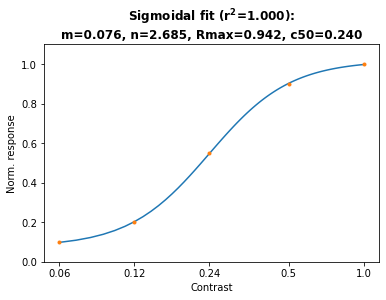

In [21]:
# CODE EXAMPLE: Sigmoidal fit to normalized tuning curve
c_data = [0.06, 0.12, 0.24, 0.5, 1.0] # Contrasts
r_data = [0.1, 0.2, 0.55, 0.9, 1.0] # Norm. responses

## Sigmoidal function
R = lambda c, m, n, Rmax, c50: (Rmax * c**n) / (c**n + c50**n) + m # Sigmoidal response function R(c) [Shapiro et al. 2021]
# R(c) ... Amplitude of the evoked response at contrast c
# m ...... Baseline response to minimum contrast
# n ...... Exponent that determines the steepness of the curve
# Rmax ... Maximum elevation in response above the baseline
# c50 .... Contrast that generates a response elevation of half Rmax

## Model fit
p_opt, _ = curve_fit(R, c_data, r_data, p0=[0.0, 1.0, 1.0, 0.25], bounds=(0, [np.inf, np.inf, np.inf, 1.0]), maxfev=10000)

## Goodness of fit
r_sq = r2_score(r_data, R(c_data, *p_opt))

## Plot
plt.figure()
c = np.arange(min(c_data), max(c_data), 0.01)
plt.plot(c, R(c, *p_opt), label='Sigmoidal fit')
plt.plot(c_data, r_data, '.', label='Data points')
plt.ylim([0.0, 1.1])
plt.gca().set_xscale('log')
plt.xticks(c_data, labels=c_data)
plt.gca().minorticks_off()
plt.xlabel('Contrast')
plt.ylabel('Norm. response')
plt.title('Sigmoidal fit ($\mathbf{r^2}$' + f'={r_sq:.3f}):\nm={p_opt[0]:.3f}, n={p_opt[1]:.3f}, Rmax={p_opt[2]:.3f}, c50={p_opt[3]:.3f}', fontweight='bold')
plt.show()